In [ ]:
a=2
a

In [96]:
import os
folder='../../runs/'
logs= [i for i in os.listdir(folder) if i.endswith('log')]

levels=['species','genus','family','order','class']
len(logs)

27

In [110]:
cases=['k19','k21','k23','k25','k27','k29','k31','RF','Oracle','Random']
log=logs[0]
dic_values={}
for level in levels:
    dic_values[level]={}
    for case in cases:
        dic_values[level][case]={}

for log in logs:
    thr1,thr2,_ = [float(i) for i in log.split('decision3')[1].split('.log')[0].split('_') if i] # 'classify_cami_max15_80_long1931_80_6sep_npath__decision3_0.2_0.1_2.log'

    with open(folder+log, 'r') as f:
        lines = f.readlines()
    for line in lines:
        #if not line.startswith('2025-09'):
        if line.startswith('=='):
            line_split=line.strip().split(',')[0].split('_')
            
            if line_split[0][2:] in levels:
                case=line_split[1]
                level=line_split[0][2:]
                F1=float(line.split(',')[1])
                precision=float(line.split(',')[2])
                recall=float(line.split(',')[3])
                TP=int(line.split(',')[4])
                FP=int(line.split(',')[5])
                VP=int(line.split(',')[6].strip())
                dic_values[level][case.strip()][(thr1,thr2)]={'F1':F1,'precision':precision,'recall':recall,'TP':TP,'FP':FP,'VP':VP}
                #print(level,F1,precision,recall,TP,FP,VP)


In [140]:
import numpy as np
level='genus' #'species'
case='RF'
thrs =[]
F1s=[]
for (thr1,thr2), dic_val in dic_values[level][case].items():
    thrs.append(str(thr1)+'_'+str(thr2))
    F1s.append(dic_val['F1'])
    #print(thr1,thr2,dic_val['F1'])
        
np.mean(F1s)

np.float64(0.884832)

In [141]:
cases_k= [i for i in cases if i.startswith('k')]
cases_k
F1_cases=[]
for case in cases_k:
    F1_cases.append(dic_values[level][case][(thr1,thr2)]['F1'])
F1_max= max(F1_cases)
case_k_max = cases_k[np.argmax(F1_cases)]
F1_max,case_k_max

(0.9064, 'k25')

In [142]:
max(F1s),thrs[np.argmax(F1s)]

(0.9035, '0.2_0.2')

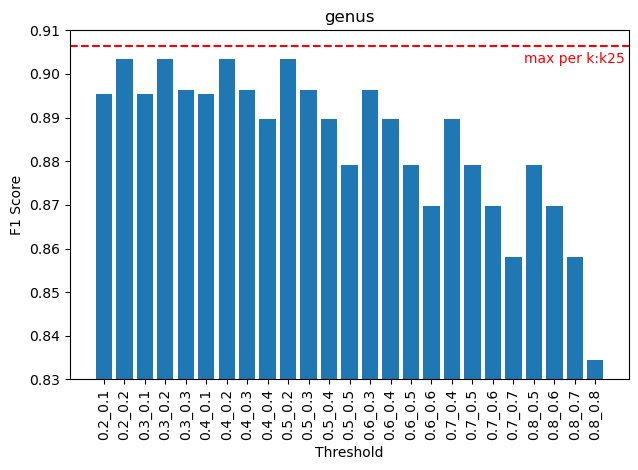

In [151]:
import matplotlib.pyplot as plt
figure=plt.figure()
plt.bar(thrs,F1s)
plt.title(level)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xticks(thrs, rotation=90)
plt.tight_layout()
plt.axhline(y=F1_max, color='red', linestyle='--')
plt.text(23, 0.995*F1_max ,'max per k:'+case_k_max, ha='center', va='bottom',color='red') # 1.01
#plt.ylim(0.78,0.82)
plt.ylim(0.83,0.91)
plt.show()

In [ ]:

# level='species'
# tresholds= set(dic_values.keys())
# cases=['k19','k21','k23','k25','k27','k29','k31','RF','Oracle','Random']
# tresholds_case= level+'_'+case
# F1_values=[dic_values[i][]['F1'] for i in tresholds]




KeyError: 'F1'

In [47]:
dic_values[(thr1,thr2)][level]

{'F1': 0.9609,
 'precision': 1.0,
 'recall': 0.9248,
 'TP': 61678,
 'FP': 0,
 'VP': 0}

NameError: name 'logs' is not defined